# 4D Behavioural Vector PDM Generation

> [1] B. G. Cangan, L. Heintzman, A. Hashimoto, N. Abaid, and R. K. Williams, ‘Anticipatory Human-Robot Path Planning for Search and Rescue’, arXiv:2009.03976 [cs], Sep. 2020, Accessed: Nov. 24, 2021. [Online]. Available: http://arxiv.org/abs/2009.03976

> [2] L. Heintzman, A. Hashimoto, N. Abaid, and R. K. Williams, ‘Anticipatory Planning and Dynamic Lost Person Models for Human-Robot Search and Rescue’, in 2021 IEEE International Conference on Robotics and Automation (ICRA), May 2021, pp. 8252–8258. doi: 10.1109/ICRA48506.2021.9562070.

> [3] A. Hashimoto and N. Abaid, ‘An Agent-Based Model of Lost Person Dynamics for Enabling Wilderness Search and Rescue’, presented at the ASME 2019 Dynamic Systems and Control Conference, Nov. 2019. doi: 10.1115/DSCC2019-9222.

In [1]:
# Setup
import copy
import sys, os
from loguru import logger

sys.path.insert(0, os.path.join(os.getcwd(), "../src")) # run from within examples folder

if os.environ.get("DEBUG", "False") == "False":
    logger.remove()
    logger.add(sys.stderr, level="INFO")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import skimage as ski

In [3]:
from FourDSim import FourDSim
from Coord import Coord
from Behaviour import BehaviourVector

## Create vectors

Generate all possible 4D vectors with 0.1 increments
Should be length 266 but is 258... is the paper wrong?

In [4]:
x = np.arange(0,1.1,0.1)
mesh = np.meshgrid(x,x,x,x)
vec = np.vstack([f.flatten() for f in mesh])
vec = vec[:,np.sum(vec,axis=0)==1.0]
vec[[0,1]] = vec[[1,0]] # prettier graphs
vec, vec.shape

(array([[0. , 0. , 0. , ..., 0.9, 0.9, 1. ],
        [0. , 0. , 0. , ..., 0. , 0.1, 0. ],
        [0. , 0.1, 0.2, ..., 0.1, 0. , 0. ],
        [1. , 0.9, 0.8, ..., 0. , 0. , 0. ]]),
 (4, 258))

Show all variations

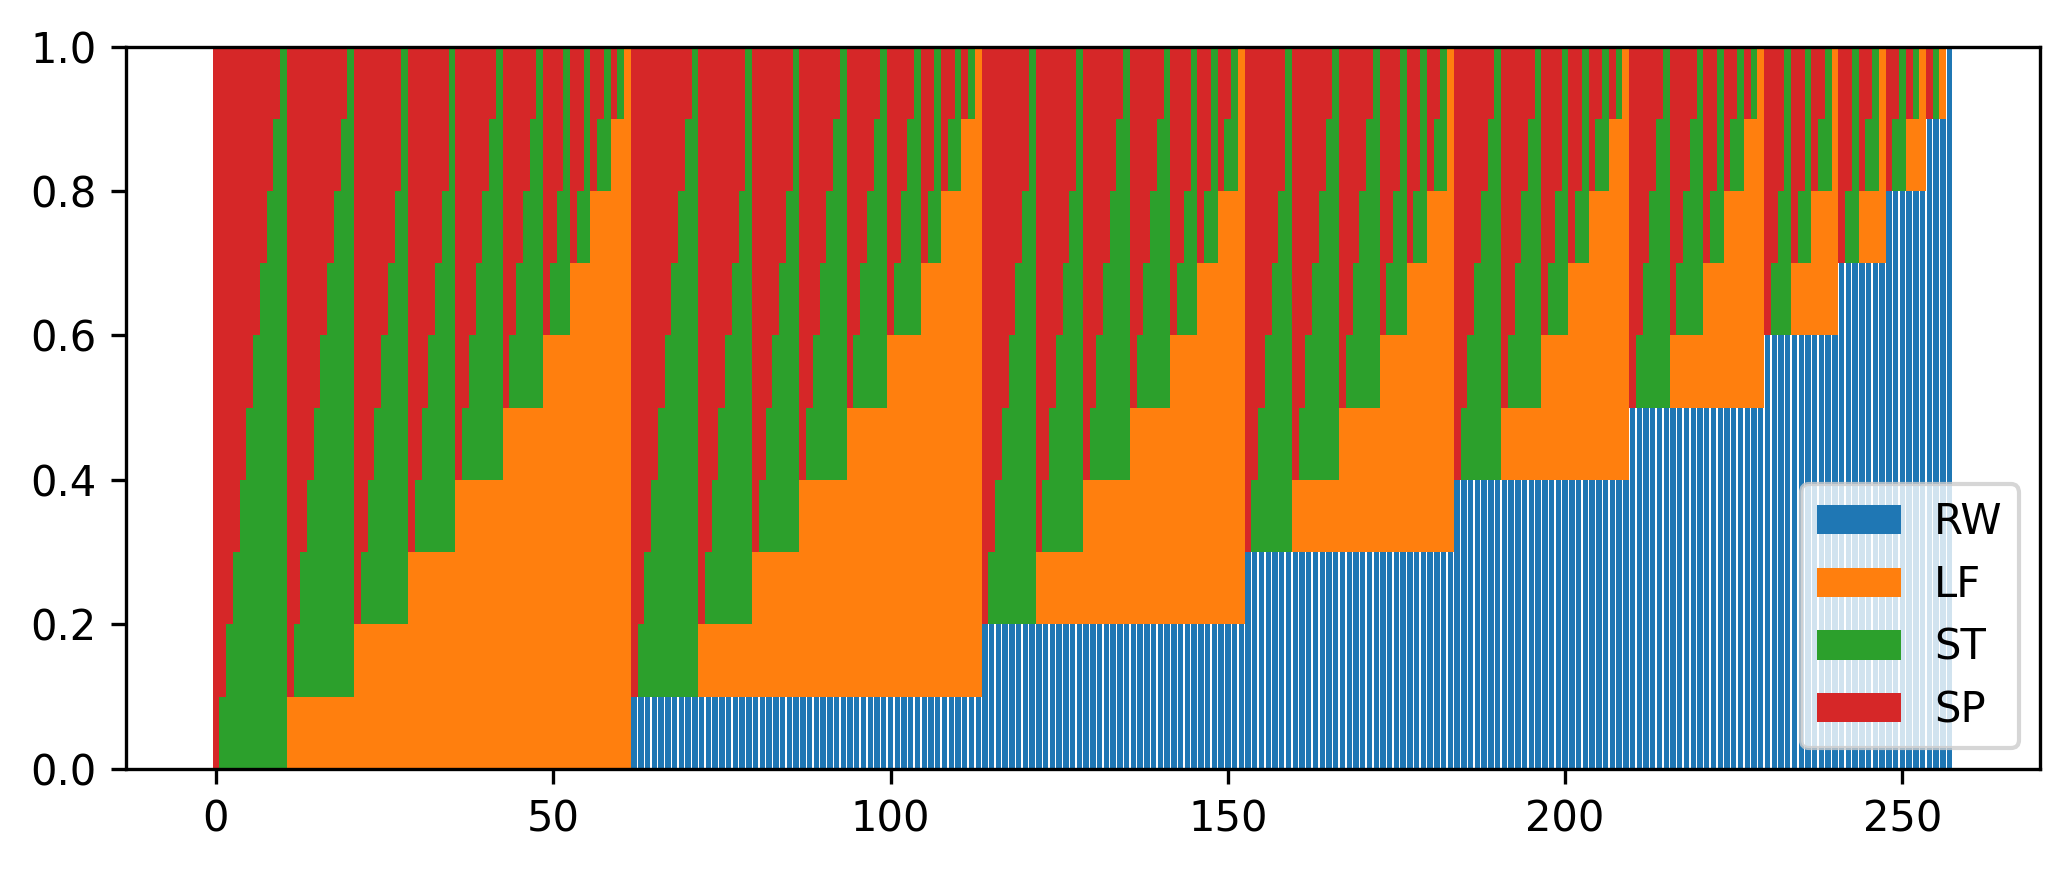

In [5]:
fig, ax = plt.subplots(figsize=(7,3), dpi=300)
x = np.arange(0,vec.shape[1])
labels = iter(['RW','LF','ST','SP'])
ax.bar(x, vec[0,:],label=next(labels))
for i in range(3):
    ax.bar(x, vec[i+1,:], width=1.0, bottom=np.sum(vec[:i+1,:],axis=0), label=next(labels))
ax.legend()
fig.tight_layout()
plt.show()

## Import GeoTIFF image with slope data

> [4]: Lidar Composite Digital Terrain Model Scotland (Phase2) 1m resolution [ASC geospatial data], Scale 1:4000, Tiles: nr82ne,nr83se,nr92nw,nr92sw,nr93sw,nr91ne,nr92ne,nr92se,nr93se,ns02ne,ns02nw,ns02se,ns02sw,ns03se,ns03sw, Updated: 1 July 2014, Non-Commercial Government Licence, Using: EDINA LIDAR Digimap Service, <https://digimap.edina.ac.uk>, Downloaded: 2022-01-28 13:08:03.643

In [6]:
import rasterio as rs
dataset_slope = rs.open('./5m_arran_b_merged_slope.tif') # You have to get these yourself
dataset_dem = rs.open('./5m_arran_b_merged.tif')

slope = dataset_slope.read(1)
slope[slope == -9999.] = 0
slope = np.deg2rad(slope) # so we don't have to worry anymore

dem = dataset_dem.read(1)

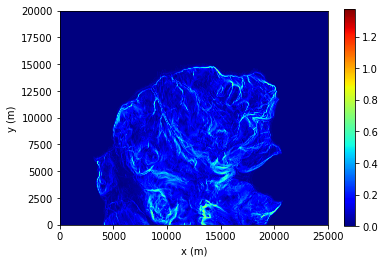

In [7]:
fig, ax = plt.subplots()
mesh = ax.imshow(slope, origin='lower', cmap='jet', extent=[0,5000*5,0,4000*5])
fig.colorbar(mesh)
ax.set_ylabel("y (m)")
ax.set_xlabel("x (m)")
plt.show()

## Canny edge detection
https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html

In [8]:
from skimage import feature

edges_rough = feature.canny(slope).astype(int)
edges = feature.canny(slope, sigma=3).astype(int)

Display results

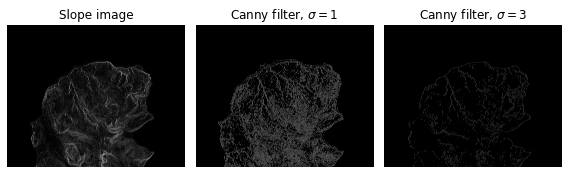

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax1.imshow(slope, cmap='gray', origin='lower')
ax1.set_title('Slope image')

ax2.imshow(edges_rough, cmap='gray', origin='lower')
ax2.set_title(r'Canny filter, $\sigma=1$')

ax3.imshow(edges, cmap='gray', origin='lower')
ax3.set_title(r'Canny filter, $\sigma=3$')

for a in [ax1,ax2,ax3]:
    a.axis('off')

fig.tight_layout()
plt.show()

## Run simulation
Code can be found [here](https://github.com/iwishiwasaneagle/jsim/tree/master/examples/FourD_Behaviour_Vector/)

In [10]:
sim = FourDSim(Coord(x=1900, y=2000))

In [11]:
sim.trials(300)

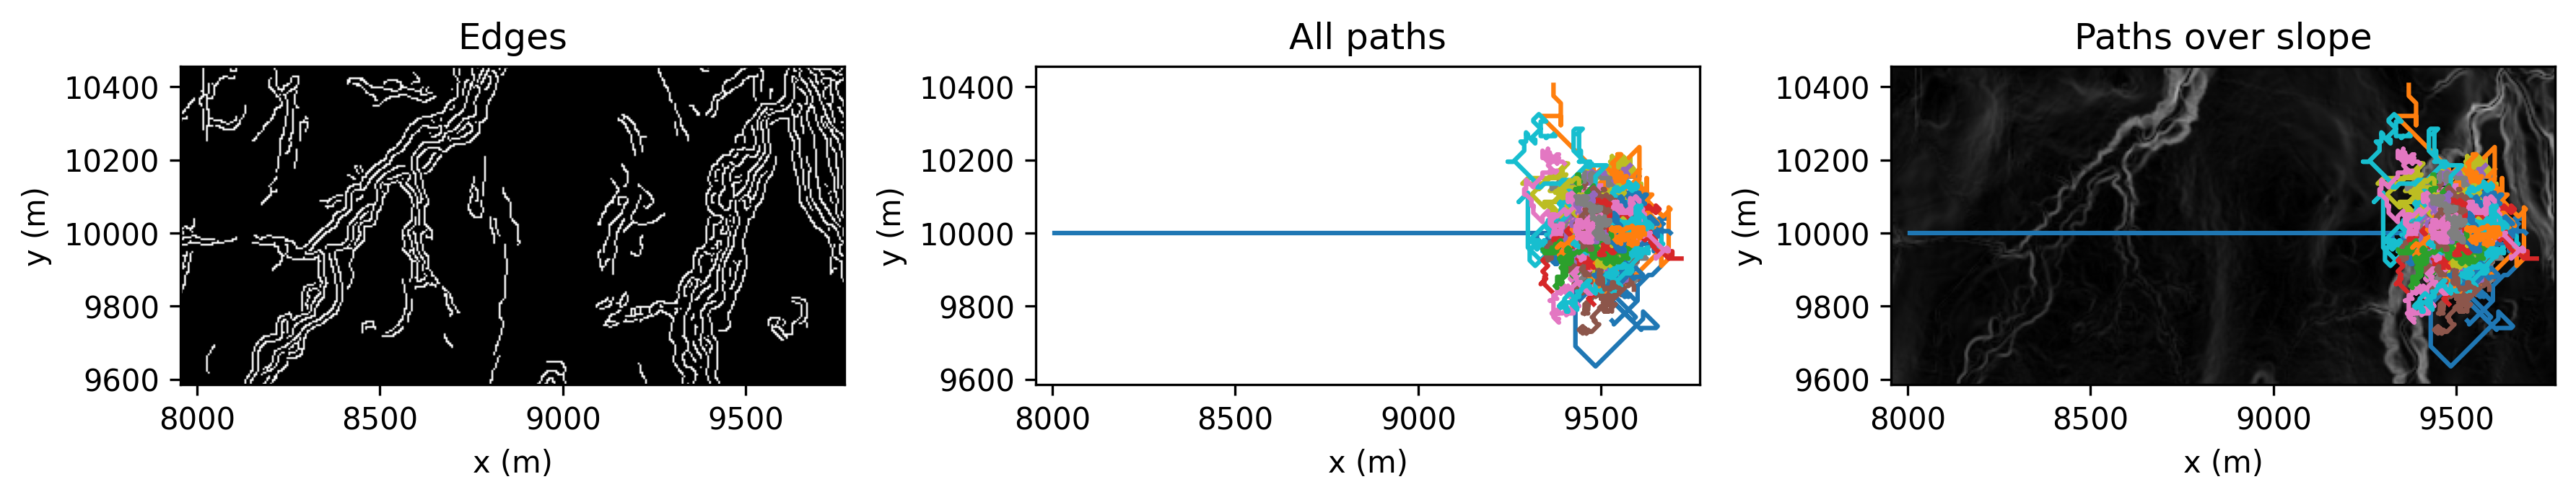

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,12), dpi=300, subplot_kw={'aspect':1})

ax1.imshow(sim.env.edges, cmap='gray', origin='lower', extent=[0,5000*5,0,4000*5])
ax3.imshow(sim.env.slope, cmap='gray', origin='lower', extent=[0,5000*5,0,4000*5])

max_x, min_x = -np.inf, np.inf
max_y, min_y = -np.inf, np.inf

x_path = {k: [f.x for f in v['coords']] for k,v in sim.long_term_ds.items()}
y_path = {k: [f.y for f in v['coords']] for k,v in sim.long_term_ds.items()}

for i in x_path.keys():
    x, y = np.array([x_path[i], y_path[i]])*5 # scale as each pixel is 5m
    max_x = max(max_x, np.max(x))
    min_x = min(min_x, np.min(x))
    max_y = max(max_y, np.max(y))
    min_y = min(min_y, np.min(y))
    [ax.plot(x, y) for ax in [ax2,ax3]]

for ax in [ax1,ax2,ax3]:
    ax.set_ylim([min_y-50, 50+max_y])
    ax.set_xlim([min_x-50, 50+max_x])
    ax.set_ylabel("y (m)")
    ax.set_xlabel("x (m)")


ax1.set_title("Edges")
ax2.set_title("All paths")
ax3.set_title("Paths over slope")
fig.tight_layout()
plt.show()

Validate the Line Following visually

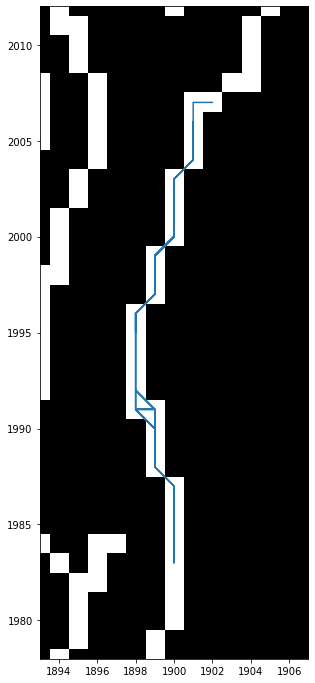

In [13]:
lf_results = next(filter( lambda x: x['bvec'] == BehaviourVector(rw=0,lf=1,st=0,sp=0).tolist(), sim.long_term_ds.values()), None)

def plot(res: dict[str,list[Coord]]):
    fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'aspect':1})
    x, y = np.array([[f.x for f in res['coords']], [f.y for f in res['coords']]])
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    ax.imshow(sim.env.edges, cmap='gray', origin='lower')
    scale = np.max((5,(max_x-min_x)//2))
    ax.set_ylim([min_y-scale, max_y+scale])
    ax.set_xlim([min_x-scale, max_x+scale])
    ax.plot(x,y)
    plt.show()

plot(lf_results)

Validate the Random Walk visually

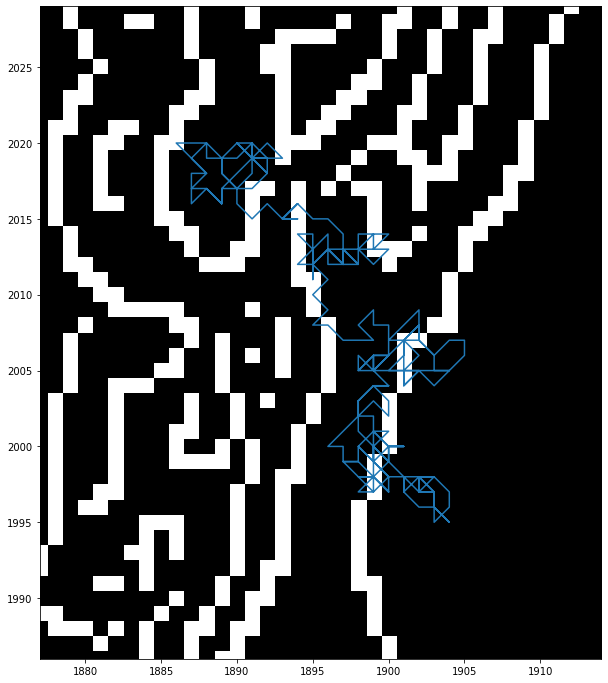

In [14]:
rw_results = next(filter( lambda x: x['bvec'] == BehaviourVector(rw=1,lf=0,st=0,sp=0).tolist(), sim.long_term_ds.values()), None)

plot(rw_results)

Validate Staying Put results visually (very interesting)

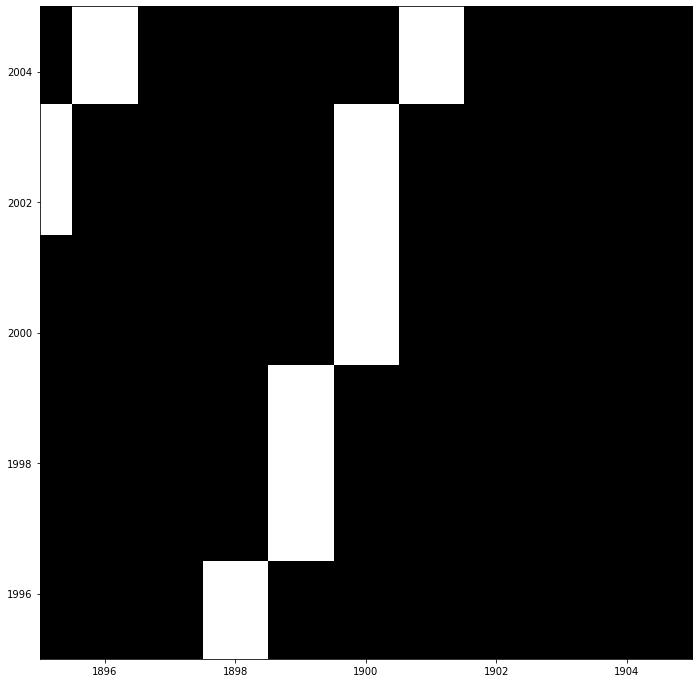

In [15]:
sp_results = next(filter( lambda x: x['bvec'] == BehaviourVector(rw=0,lf=0,st=0,sp=1).tolist(), sim.long_term_ds.values()), None)

plot(sp_results)

Validate Straight Travel results visually

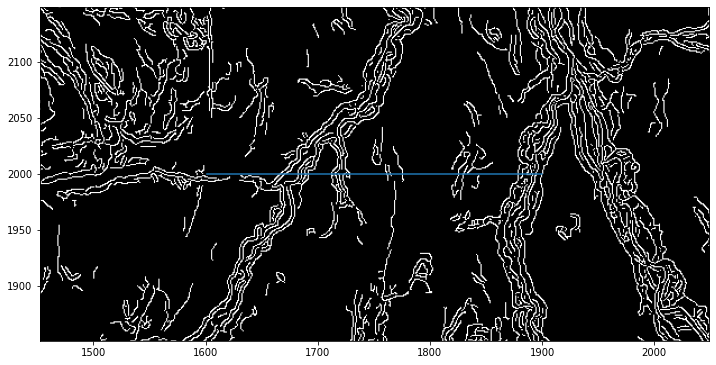

In [16]:
st_results = next(filter( lambda x: x['bvec'] == BehaviourVector(rw=0,lf=0,st=1,sp=0).tolist(), sim.long_term_ds.values()), None)

plot(st_results)

## Use agent to generate PDM
TODO: Select "best" agent. Pick one at random for now

> Simulations were run for the time it would take for a
person to walk an hour with an average pace of 4 kilometers an
hour and with a time step of 6 seconds, that is T = 600.

- [3]

Thus, each cell is $5m$ wide. Not accounting for diagonal steps, slope, etc., we run the simulation for $800$ timesteps.

In [17]:
agent = BehaviourVector(rw=0.05,lf=0.9,st=0.05,sp=0.0) # it's probably the most interesting

n_trials = 100000
n_steps = 250
start = Coord(x=1900,y=2000)

def bvecs():
    for _ in tqdm(range(n_trials)):
        yield copy.deepcopy(agent)

old_cd = FourDSim.collect_data
def monkeypatch_collect_data(self, ps: Coord) -> None:
    self.data_store = (ps.x, ps.y)
FourDSim.collect_data = monkeypatch_collect_data

pdm_sim = FourDSim(start, bvecs=bvecs())
pdm_sim.trials(n_steps)
FourDSim.collect_data = old_cd

  0%|          | 0/100000 [00:00<?, ?it/s]

In [20]:
end_locations = np.array([f for f in pdm_sim.long_term_ds.values()])

min_x, min_y = np.min(end_locations, axis=0)
max_x, max_y = np.max(end_locations, axis=0)
end_locations[:,0] -= min_x
end_locations[:,1] -= min_y
z = np.zeros((max_y-min_y+1, max_x-min_x+1))
for xi, yi in end_locations:
    z[yi,xi] += 1

z = ski.filters.gaussian(z, 2)
z = np.ma.masked_where(z == 0, z)
z /= np.sum(z)

min_x *= 5
max_x *= 5
min_y *= 5
max_y *= 5

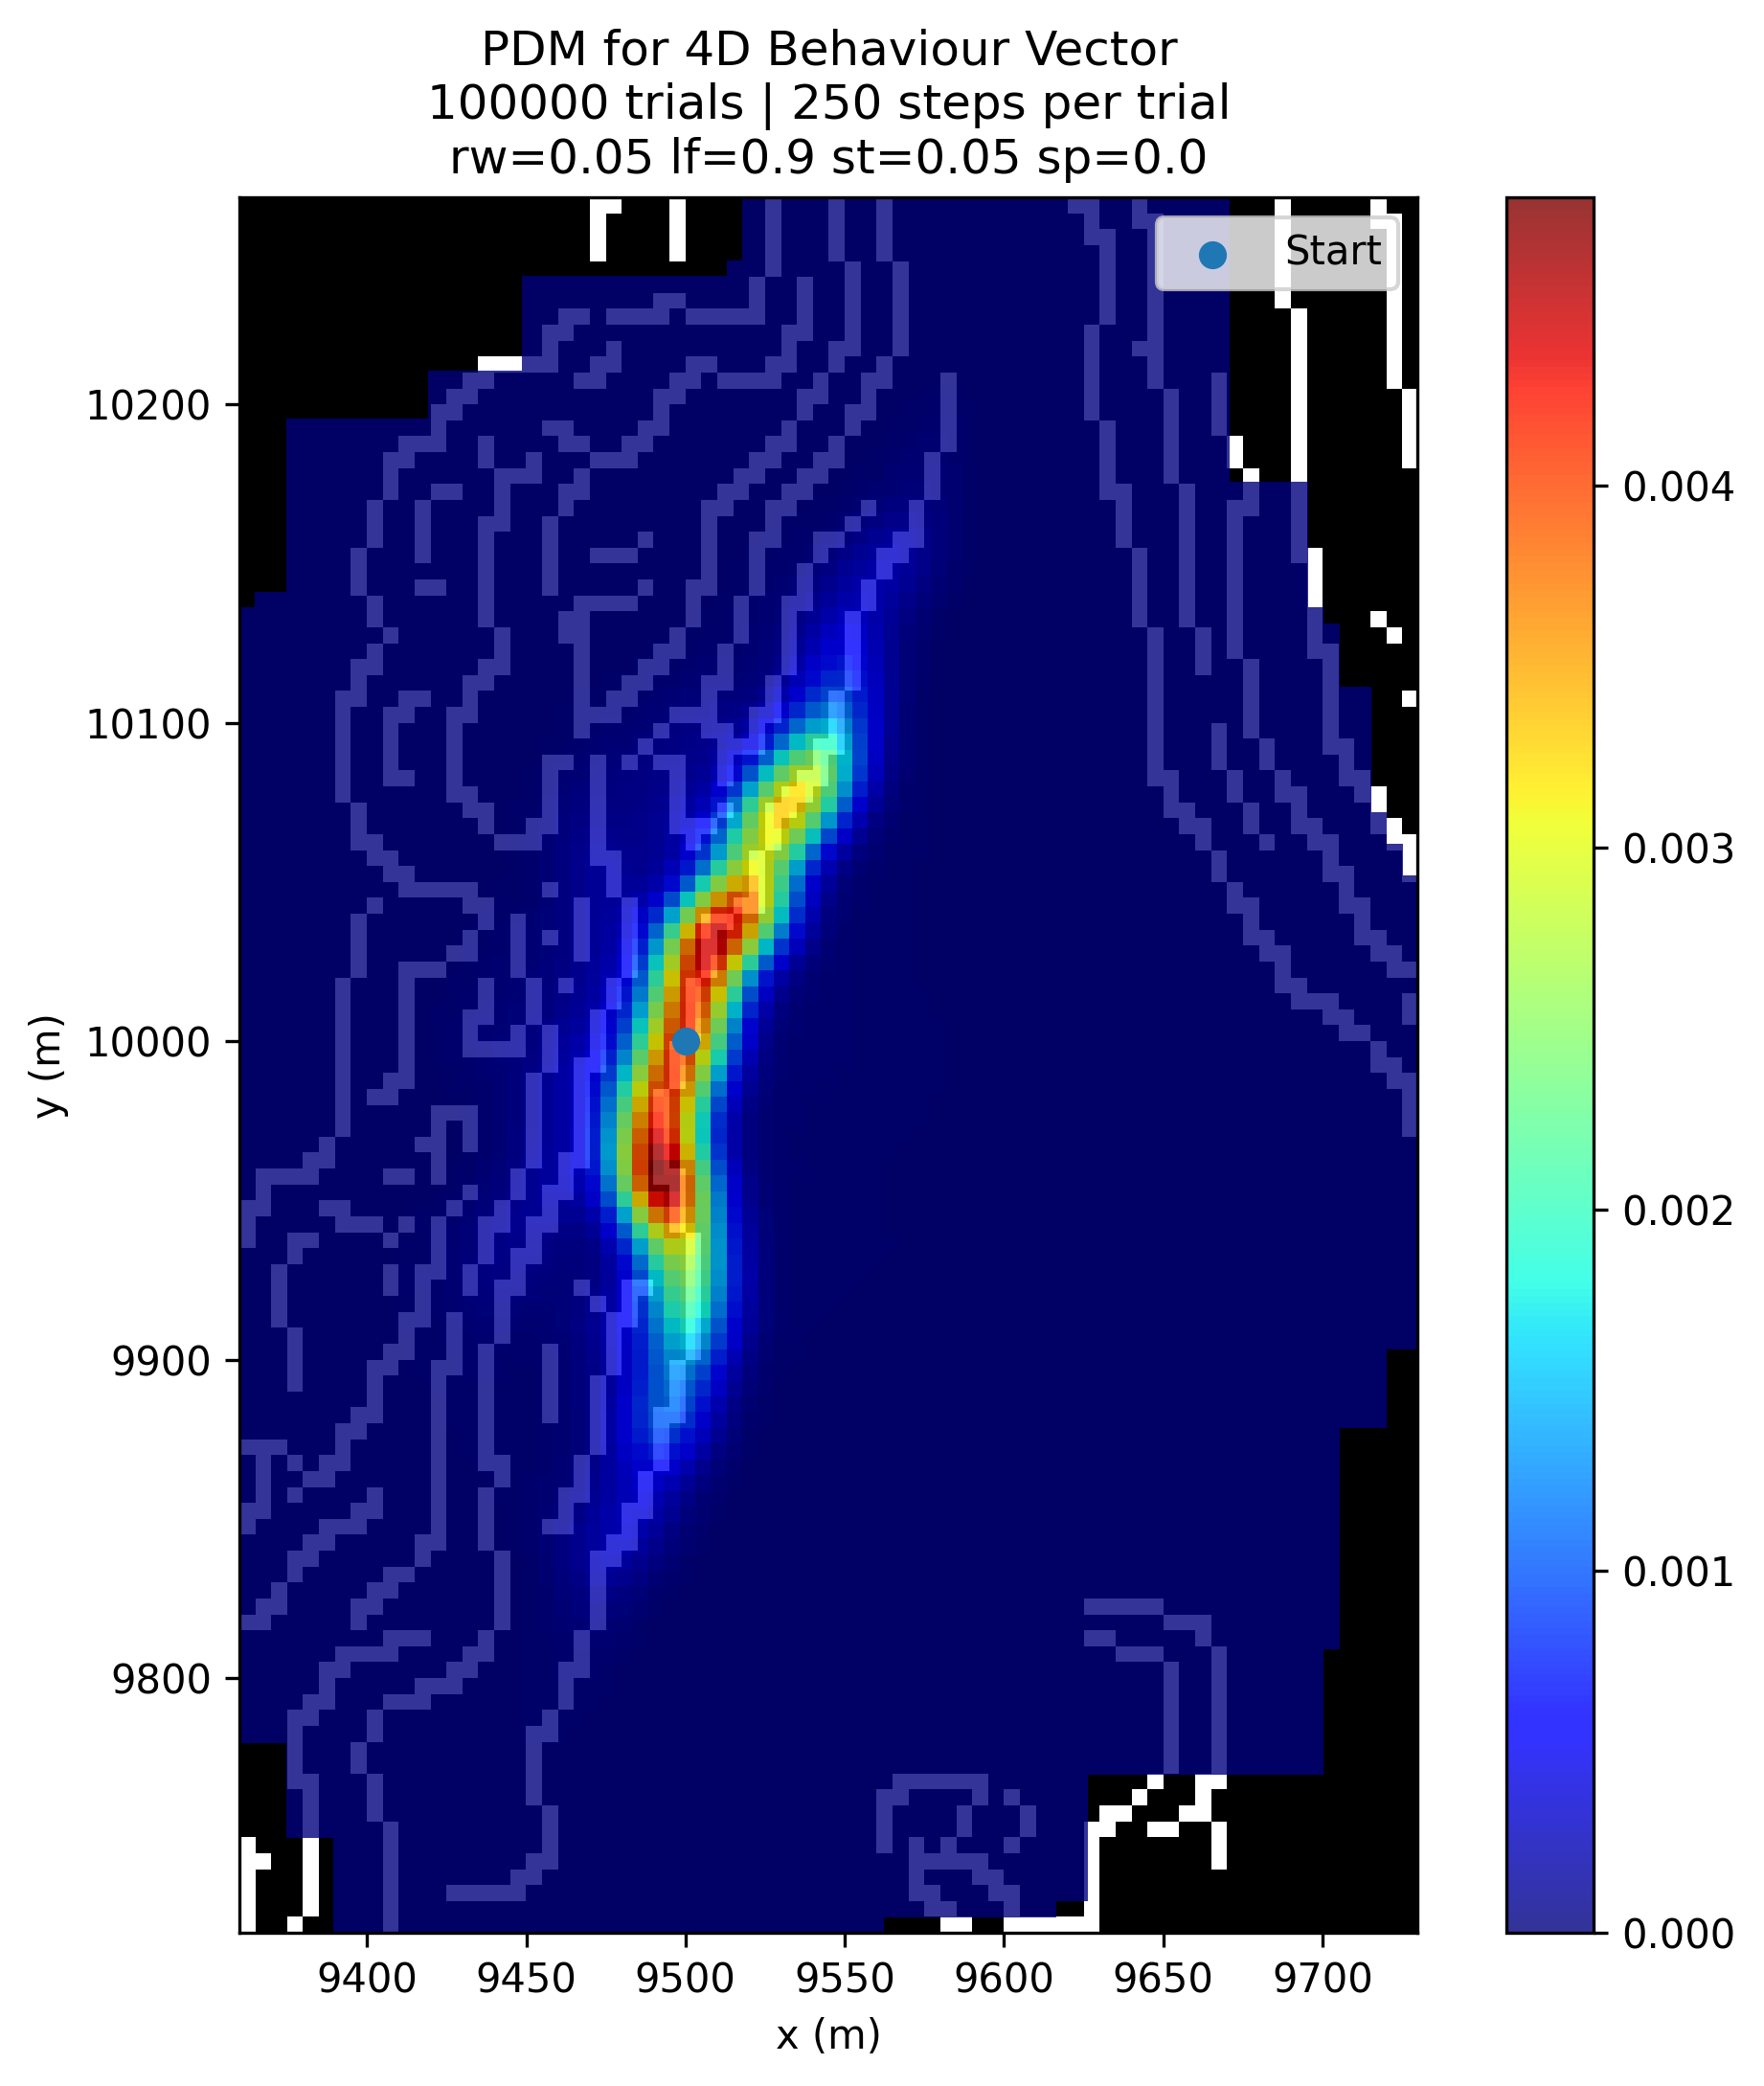

In [21]:
fig, ax = plt.subplots(figsize=(8,8),dpi=300)

ax.imshow(pdm_sim.env.edges, cmap='gray', origin='lower',extent=[0,5*pdm_sim.env.edges.shape[1], 0, 5*pdm_sim.env.edges.shape[0]])

z_plt = ax.imshow(z, cmap='jet', origin='lower', interpolation='None', extent=[min_x,max_x,min_y,max_y], alpha=0.8)
fig.colorbar(z_plt)

ax.scatter(start.x*5, start.y*5, label='Start')

ax.set_title(f"PDM for 4D Behaviour Vector\n{n_trials} trials | {n_steps} steps per trial\n{agent}")
ax.set_xlabel(f"x (m)")
ax.set_ylabel(f"y (m)")
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
ax.legend()
ax.set_aspect('equal')
plt.show()